In [184]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import os
import math

#from source.utils import split_run_results

In [185]:
'''
    USER INPUT
'''

DO_SAVE = True
#run_names = ['resnet101_pr50_lcm0.0001_batch16', 'resnet101_pr75_lcm0.0001_batch16', 'resnet101_pr85_lcm0.0001_batch16'] # these logs dont have rx ip and port yet 
#run_names = ['resnet18_pr50_lcm0.0001_batch64', 'resnet18_pr75_lcm0.0001_batch64', 'resnet18_pr85_lcm0.0001_batch64'] # these logs dont have rx ip and port yet
run_names = [ 'filter']
num_runs = len(run_names)
test_name = run_names[0]
log_name = 'resnet18'
num_nodes = 4

save_dir = os.path.join('assets', 'figs', test_name)
log_file_path = os.path.join('logs', test_name)

if DO_SAVE:
    os.makedirs(save_dir, exist_ok=True)

In [186]:

def parse_log_file(log_file_path):
    ''' 
        Regular expressions to capture the timestamp and data from each log message type AND
        Initialize empty lists for storing the data

        Ouput:
            block_event_df - tracks the start of each "block" event i.e. EXECUTE a block of non-comms layers, main process IDLE time, TX, RX, PREP time spent preparing outputs for sending
            layer_event_df - tracks timestamps for when each layer in the model finishes and the FLPOS computed 
            total_runtime - array with total runtimes in seconds
    '''

    timestamp_regex = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})"

    # Idle time
    idle_time_regex = re.compile(timestamp_regex + r" .*Idle time=(\d+\.?\d*)ms for layer=(\d+)")
    idle_time_data = []
    
    # Layer execution
    execute_layer_ts_regex = re.compile(timestamp_regex + r" .*Executed layer=(\d+) ([^;]*)\n")
    execute_layers_regex = re.compile(timestamp_regex + r" .*Executed to ([^;]*) layer=(\d+) in time=(\d+\.?\d*)ms process input time=(\d+\.?\d*)ms")
    execute_layer_ts_data = []
    execute_layers_data = []

    # transmit routines
    total_send_regex= re.compile(timestamp_regex + r" .*Sent layer=(\d+) to nodes in time=(\d+\.?\d*)ms")
    send_data_regex = re.compile(timestamp_regex + r" .*Sent data ACKOWLEDGED for layer=(\d+) time=(\d+\.?\d*)ms bytes=(\d+) serialize time=(\d+\.?\d*)ms encode time=(\d+\.?\d*)ms ip=([\d\.]+) port=(\d+)")
    prep_out_regex = re.compile(timestamp_regex + r" .*layer=(\d+) time=(\d+\.?\d*)ms")
    total_send_data = []
    send_data = []
    prep_out_data = []
    
    # receive routines
    received_layer_regex = re.compile(timestamp_regex + r" .*Received layer=(\d+): receive time=(\d+\.?\d*)ms, deserialize time=(\d+\.?\d*)ms bytes=(\d+)")
    received_layer_data = []

    # total runtime
    total_runtime_regex = re.compile(timestamp_regex + r" .*Total runtime=(\d+\.?\d*)s")

    # Read the log file and extract relevant data
    with open(log_file_path, 'r') as file:
        for line in file:
            # Check for idle time messages
            idle_time_match = idle_time_regex.search(line)
            if idle_time_match:
                idle_time_data.append({
                    'timestamp': idle_time_match.group(1),
                    'dur': float(idle_time_match.group(2)),
                    'layer': int(idle_time_match.group(3))
                })
                continue
            
            # Check for executed layer timestamps 
            execute_layer_ts_match = execute_layer_ts_regex.search(line)
            if execute_layer_ts_match:
                execute_layer_ts_data.append({
                    'timestamp': execute_layer_ts_match.group(1),
                    'layer': int(execute_layer_ts_match.group(2)),
                    'layer_name': str(execute_layer_ts_match.group(3))
                })
                continue

            # Check for executed layer messages (for layer blocks  vs individual)
            execute_layers_match = execute_layers_regex.search(line)
            if execute_layers_match:
                execute_layers_data.append({
                    'timestamp': execute_layers_match.group(1),
                    'layer_name': str(execute_layers_match.group(2)),
                    'layer': int(execute_layers_match.group(3)),
                    'dur': float(execute_layers_match.group(4)), 
                    'process_dur': float(execute_layers_match.group(5))
                })
                continue

            # Check for sent data ACKOWLEDGED messages
            send_data_match = send_data_regex.search(line)
            if send_data_match:
                send_data.append({
                    'timestamp': send_data_match.group(1),
                    'layer': int(send_data_match.group(2)),
                    'dur': float(send_data_match.group(3)),
                    'bytes_tx': int(send_data_match.group(4)),
                    'serialize_dur': float(send_data_match.group(5)),
                    'encode_dur_tx': float(send_data_match.group(6)),
                    'ip' : send_data_match.group(7),
                    'port' : float(send_data_match.group(8))
                })
                continue

            # Check for total time sent messages
            total_send_match = total_send_regex.search(line)
            if total_send_match:
                total_send_data.append({
                    'timestamp': total_send_match.group(1),
                    'layer': int(total_send_match.group(2)),
                    'dur': float(total_send_match.group(3))
                })
                continue
            
            # Prep out data
            prep_out_match = prep_out_regex.search(line)
            if prep_out_match:
                prep_out_data.append({
                    'timestamp': prep_out_match.group(1),
                    'layer': int(prep_out_match.group(2)),
                    'dur': float(prep_out_match.group(3))
                })

            # Check for received layer messages
            received_layer_match = received_layer_regex.search(line)
            if received_layer_match:
                received_layer_data.append({
                    'timestamp': received_layer_match.group(1),
                    'layer': int(received_layer_match.group(2)),
                    'dur': float(received_layer_match.group(3)),
                    'deserialize_time': float(received_layer_match.group(4)),
                    'bytes_rx': int(received_layer_match.group(5))
                })
            
            total_runtime_match = total_runtime_regex.search(line)
            if total_runtime_match:
                total_runtime = float(total_runtime_match.group(2))

    # get flops per layer calculated elswhere
    flops_file_path = log_file_path[:-4] + '_debug.log'
    flops_df = parse_debug_log_file(flops_file_path)

    # Convert the lists into pandas DataFrames
    idle_time_df = pd.DataFrame(idle_time_data)
    execute_layer_ts_df = pd.DataFrame(execute_layer_ts_data)
    execute_layers_df = pd.DataFrame(execute_layers_data)
    send_data_df = pd.DataFrame(send_data)
    total_send_data_df = pd.DataFrame(total_send_data)
    prep_out_df = pd.DataFrame(prep_out_data)
    received_layer_df = pd.DataFrame(received_layer_data)

    # convert timestamp strings to datetime
    time_format_str = '%Y-%m-%d %H:%M:%S,%f'
    idle_time_df['timestamp'] = pd.to_datetime(idle_time_df['timestamp'], format=time_format_str)
    execute_layer_ts_df['timestamp'] = pd.to_datetime(execute_layer_ts_df['timestamp'], format=time_format_str)
    execute_layers_df['timestamp'] = pd.to_datetime(execute_layers_df['timestamp'], format=time_format_str)
    send_data_df['timestamp'] = pd.to_datetime(send_data_df['timestamp'],format=time_format_str)
    total_send_data_df['timestamp'] = pd.to_datetime(total_send_data_df['timestamp'],format=time_format_str)
    prep_out_df['timestamp'] = pd.to_datetime(prep_out_df['timestamp'],format=time_format_str)
    received_layer_df['timestamp'] = pd.to_datetime(received_layer_df['timestamp'], format=time_format_str)
    flops_df['timestamp'] = pd.to_datetime(flops_df['timestamp'], format=time_format_str)

    # zero to 1st entry across all messages TODO: use starting model debug message as reference 
    start_date = min(pd.concat([idle_time_df['timestamp'], execute_layer_ts_df['timestamp'],  execute_layers_df['timestamp'], send_data_df['timestamp'], total_send_data_df['timestamp'], received_layer_df['timestamp']]))
    idle_time_df['time'] = (idle_time_df['timestamp'] -start_date).dt.total_seconds()*1e3
    execute_layer_ts_df['time'] = (execute_layer_ts_df['timestamp'] - start_date).dt.total_seconds()*1e3
    execute_layers_df['time'] = (execute_layers_df['timestamp']-start_date).dt.total_seconds()*1e3
    send_data_df['time'] = (send_data_df['timestamp']-start_date).dt.total_seconds()*1e3
    total_send_data_df['time'] = (total_send_data_df['timestamp']-start_date).dt.total_seconds()*1e3
    prep_out_df['time'] = (prep_out_df['timestamp']-start_date).dt.total_seconds()*1e3
    received_layer_df['time'] = (received_layer_df['timestamp']-start_date).dt.total_seconds()*1e3

    # make uniform formating to prepare for merge
    # - each row is an event
    # - timestamp is the time the event starts 
    # - each event has 4 base cols: timestamp [ms], type [idle/tx/rx/prep], layer (event operates on this layer), dur [ms], 

    def adjust_df(df, type):
        df['type'] = type
        df['timestamp'] = df['timestamp'] - pd.to_timedelta(df['dur'], unit='ms')
        df['time'] = df['time'] - df['dur']
        return df

    idle_time_df = adjust_df(idle_time_df, 'idle')
    execute_layers_df = adjust_df(execute_layers_df, 'execute')
    send_data_df = adjust_df(send_data_df,'send') 
    total_send_data_df = adjust_df(total_send_data_df, 'total_send')
    prep_out_df = adjust_df(prep_out_df, 'prep')
    received_layer_df = adjust_df(received_layer_df, 'receive')

    # merge
    block_event_df = pd.concat([idle_time_df, execute_layers_df, send_data_df, total_send_data_df, prep_out_df, received_layer_df], ignore_index=True, sort=False)
    block_event_df = block_event_df.sort_values(by='timestamp')
    
    # add FLOPS to execute layer timestamps
    flops_df = flops_df.drop(columns=['timestamp'])
    layer_event_df = pd.merge(execute_layer_ts_df, flops_df, on=['layer_name', 'layer'], how='outer')
    layer_event_df.sort_values(by=['timestamp'])
    layer_event_df['time'] = (layer_event_df['timestamp'] -start_date).dt.total_seconds()

    return block_event_df, layer_event_df, total_runtime


def parse_debug_log_file(log_file_path):
    ''' 
        Parses extra outputs from split manager when the debug flag is enabled.
        To get these extra outputs, a second run is required.
        Extra outputs are: FLOPS, num_parameters
        It is assumed that if the debug flag is enabled the computation will be slowed and delay results will be adversely effected 
        THEREFORE, a second run is required. 
    '''
    # Regular expressions to capture the timestamp and data from each log message type
    timestamp_regex = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})"

    #2024-09-21 18:15:00,763 - source.core.split_manager - DEBUG - FLOPS for conv1 layer=1 FLOPS=589824.0 parameters=576.0
    flops_regex = re.compile(timestamp_regex + r" .*FLOPS for ([^;]*) layer=(\d+) FLOPS=(\d+\.?\d*) parameters=(\d+\.?\d*)")

    # Initialize empty lists for storing the data
    flops_data = []

    # Read the log file and extract relevant data
    with open(log_file_path, 'r') as file:
        for line in file:
            # Check for idle time messages
            flops_match = flops_regex.search(line)
            if flops_match:
                flops_data.append({
                    'timestamp': flops_match.group(1),
                    'layer_name': str(flops_match.group(2)),
                    'layer': int(flops_match.group(3)), 
                    'FLOPS': float(flops_match.group(4)),
                    'parameters': float(flops_match.group(5))
                })
                continue

    # Convert the lists into pandas DataFrames
    flops_df = pd.DataFrame(flops_data)

    # Save DataFrames to CSV (optional)
    '''
    idle_time_df.to_csv('flops_df.csv', index=False)
    '''

    # Print DataFrames to verify
    #print("FLOPS DataFrame:")
    #print(flops_df)

    return flops_df

'''
    Get data for each log file
'''
def combine_log_files(log_file_path, log_name_substr, num_nodes):
    '''
        Combines log files between nodes, and merges log files that time contiguous blocks 
    '''
    total_runtime = []
    for i in range(num_nodes):
        #print(f'\n\n Network Node {i}')
        node_log_file_path= os.path.join(log_file_path,f'node{i}_{log_name_substr}.log')
        block_event_tmp, layer_event_tmp, total_runtime_tmp = parse_log_file(node_log_file_path)

        total_runtime.append(total_runtime_tmp)

        block_event_tmp['node'] = i
        layer_event_tmp['node'] = i

        if i ==0:
            block_event_df = block_event_tmp
            layer_event_df = layer_event_tmp
        else:
            block_event_df = pd.concat([block_event_df, block_event_tmp])
            layer_event_df = pd.concat([layer_event_df, layer_event_tmp])

    # zero to 1st entry across all messages TODO: use starting model debug message as reference 
    start_time = min(pd.concat([block_event_df['timestamp'], layer_event_df['timestamp']]))
    block_event_df['time'] = (block_event_df['timestamp'] -start_time).dt.total_seconds()*1e3
    layer_event_df['time'] = (layer_event_df['timestamp'] - start_time).dt.total_seconds()*1e3

    block_event_df = block_event_df.sort_values(by=['time'])
    layer_event_df = layer_event_df.sort_values(by=['time'])

    #master_df[key] = master_df[key].fillna(0)

    # rearrange columns 
    block_event_df = block_event_df[['timestamp', 'time', 'node', 'layer', 'layer_name','type', 'dur', 'process_dur', 'bytes_tx', 'serialize_dur', 'encode_dur_tx','ip', 'port', 'bytes_rx', 'deserialize_time']]
    layer_event_df = layer_event_df[['timestamp', 'time', 'node', 'layer', 'layer_name', 'FLOPS', 'parameters']]

    # Save DataFrames to CSV 
    block_event_df.to_csv(os.path.join(log_file_path,'block_events.csv'), index=False)
    layer_event_df.to_csv(os.path.join(log_file_path,'layer_events.csv'), index=False)

    return block_event_df, layer_event_df, total_runtime


In [187]:
block_event_df, layer_event_df, total_runtime = combine_log_files(log_file_path, log_name, num_nodes)

In [188]:
''' 
    Make block event timeline plot
'''
#block_event_df[block_event_df['node'] == 0][['type', 'timestamp','time','dur', 'type']].head(7)
block_event_df


,timestamp,time,node,layer,layer_name,type,dur,process_dur,bytes_tx,serialize_dur,encode_dur_tx,ip,port,bytes_rx,deserialize_time
144,2024-10-06 23:50:32.335917400,0.000000,1,0,NaN,receive,0.0826,NaN,NaN,NaN,NaN,NaN,NaN,16519.0,0.3179
22,2024-10-06 23:50:32.336407700,0.490300,1,1,conv1,execute,1.5923,0.2771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2024-10-06 23:50:32.337000000,1.082600,1,0,NaN,idle,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,2024-10-06 23:50:32.337871601,1.954201,2,0,NaN,receive,0.1284,NaN,NaN,NaN,NaN,NaN,NaN,16519.0,0.3741
102,2024-10-06 23:50:32.338151200,2.233800,1,1,NaN,total_send,5.8488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2024-10-06 23:50:33.550486601,1214.569201,2,69,NaN,send,0.5134,NaN,205.0,0.1105,0.0012,127.0.0.1,5001.0,NaN,NaN
205,2024-10-06 23:50:33.550984900,1215.067500,1,69,NaN,receive,0.0151,NaN,NaN,NaN,NaN,NaN,NaN,205.0,0.3407
100,2024-10-06 23:50:33.552118500,1216.201100,3,69,NaN,send,0.8815,NaN,205.0,0.1326,0.0012,127.0.0.1,5001.0,NaN,NaN
206,2024-10-06 23:50:33.552686300,1216.768900,1,69,NaN,receive,0.3137,NaN,NaN,NaN,NaN,NaN,NaN,205.0,0.5956


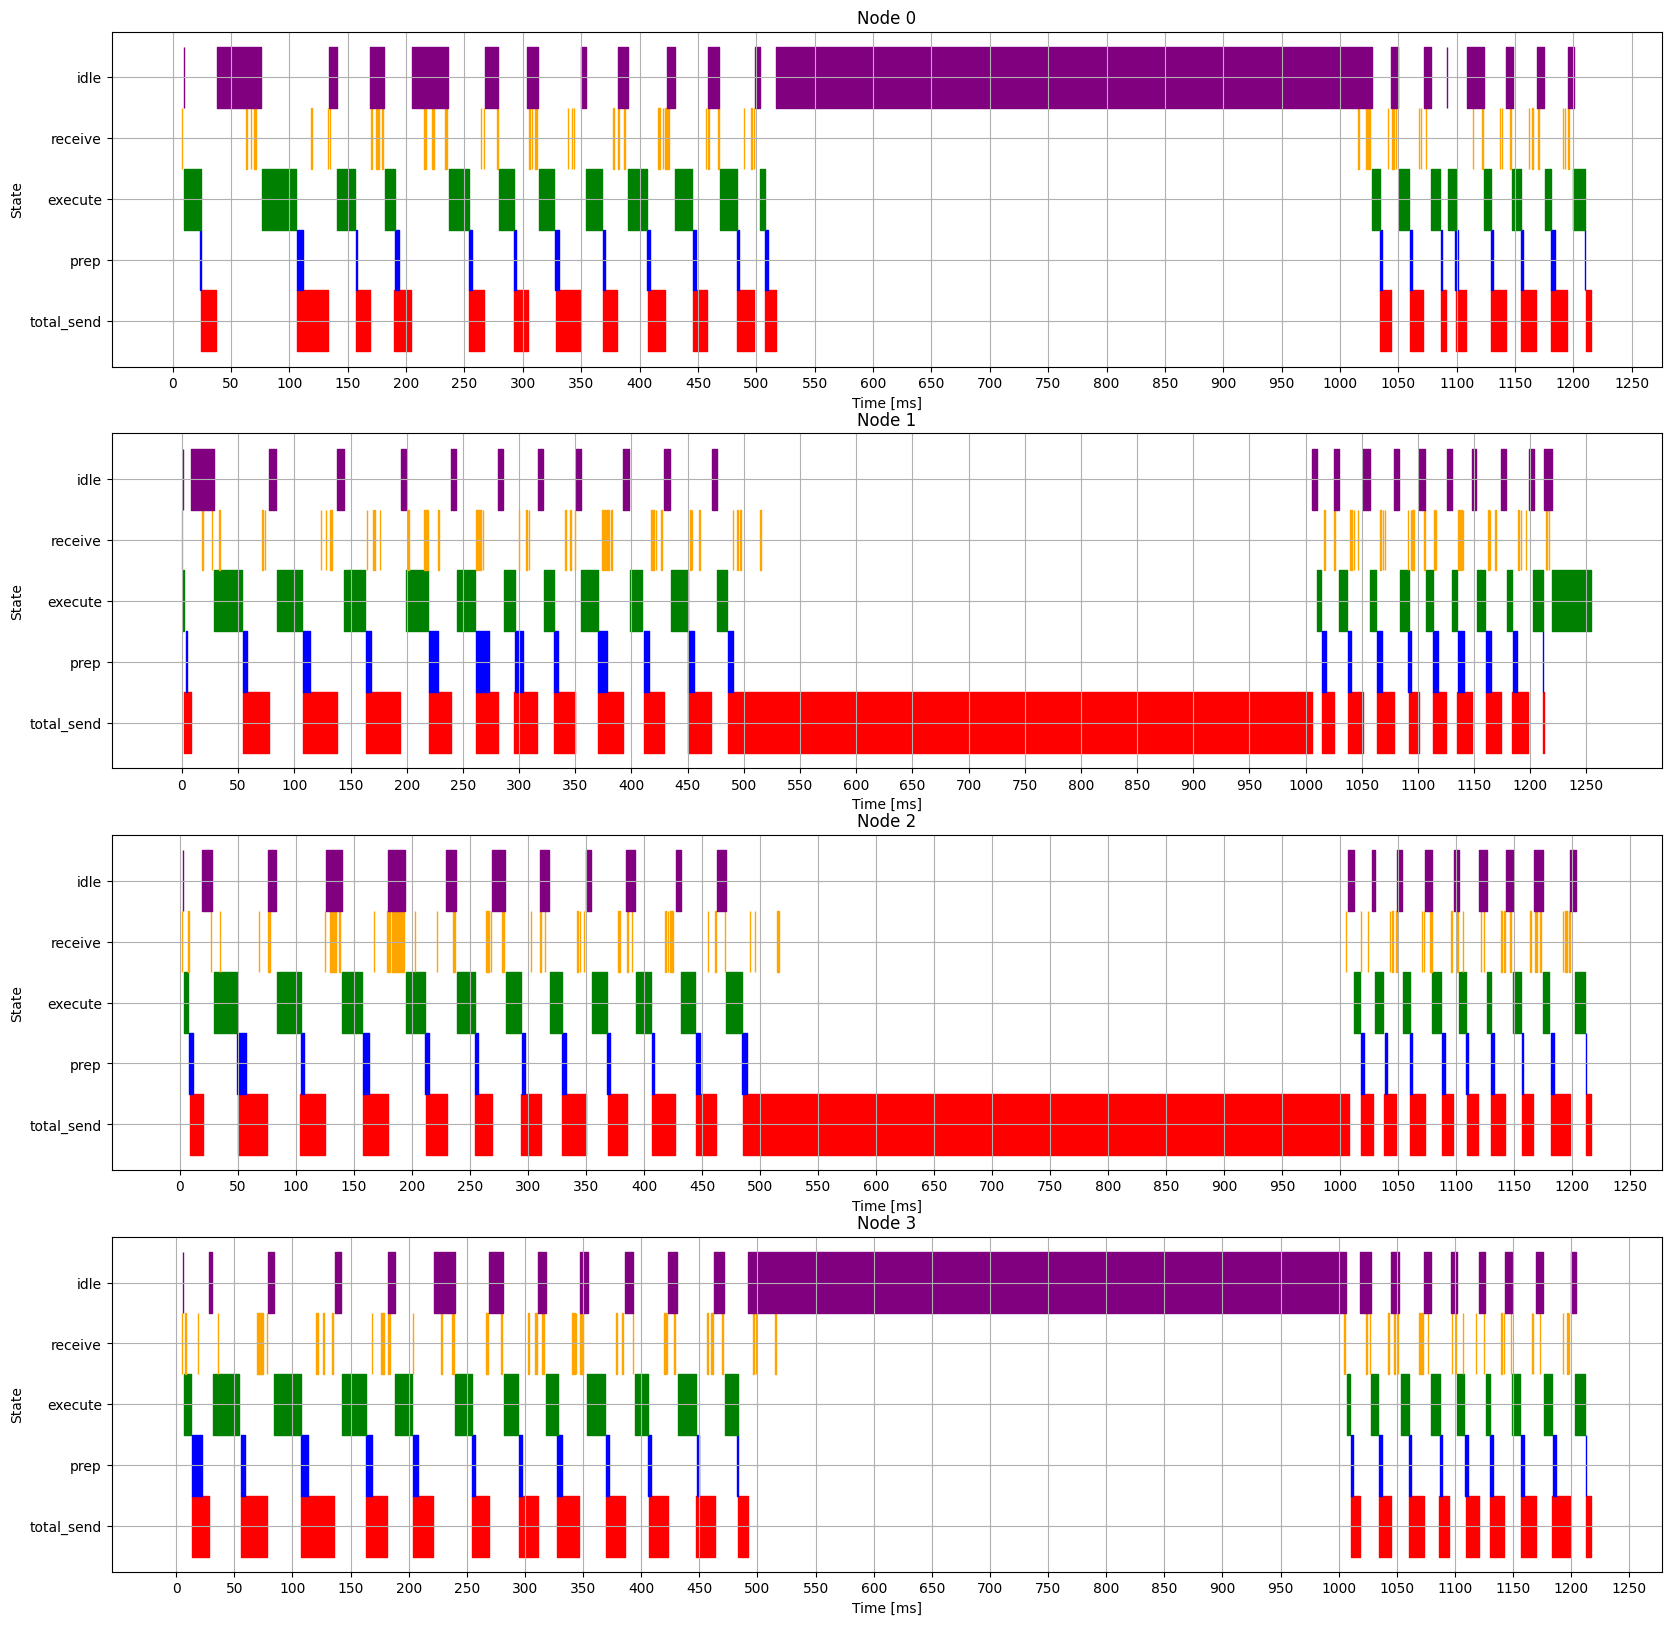

In [189]:
'''
    Plot timeline 
'''

def seq_of_tuples(df, col1, col2):
    return list(zip(df[col1], df[col2]))

# get layers that wait on inputs 
begin_block_layers = np.unique(block_event_df['layer'].to_numpy())

yheigth = 1
ystep = 1

comms_width = yheigth/num_nodes

fig, axs = plt.subplots(num_nodes, 1)
fig.set_size_inches(20,20)

# TODO: do for each node
inode = 0
state_types = ['total_send', 'prep','execute', 'receive', 'idle']
color_list = ['red', 'blue', 'green', 'orange', 'purple']
num_states = len(state_types)

for inode in range(num_nodes):
    axs[inode].grid()
    for istate in range(num_states):

        state_type = state_types[istate]

        # format data and plot
        bars = seq_of_tuples(block_event_df.loc[(block_event_df['node'] == inode) & (block_event_df['type'] == state_type)], 'time', 'dur')
        axs[inode].broken_barh(bars, (ystep*istate - yheigth/2,yheigth), color=color_list[istate])


    title_str = f'Node {inode}'
    axs[inode].set_title(title_str)
    axs[inode].set_xlabel('Time [ms]')
    axs[inode].set_ylabel('State')
    axs[inode].set_yticks(ticks=range(0, num_states*ystep, ystep), labels=state_types)

    xlim_range = []#[0, 200] #[700, 800]
    step_size = 50

    if [] == xlim_range:
        axs[inode].set_xticks(range(0, math.ceil(max(total_runtime)*1e3), step_size))
    else:
        axs[inode].set_xlim(xlim_range)
        axs[inode].set_xticks(range(xlim_range[0], xlim_range[1], step_size))
    
    #plt.legend(state_types)
    #plt.xlim(0,max(total_runtime)*1.1)

#fig.show()
#plt.ion()
#_ = plt.show()
    

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'block_execution_time.jpg'))




In [190]:
'''
    Make scatter plots for TX and RX
'''

ax_send = send_data_df.plot.scatter(x='send_time', y='bytes_tx')
ax_send.set_xlabel('Time [ms]')
ax_send.set_ylabel('Data Size [Bytes]')
ax_send.set_title('Datarate')
ax_send.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_send.jpg'))

# TODO: fix the measurment of time in debugger logging
ax_receive = received_layer_df.plot.scatter(x='receive_time', y='bytes_rx')
ax_receive.set_xlabel('Time [ms]')
ax_receive.set_ylabel('Data Size [Bytes]')
ax_receive.set_title('Receive Time')
ax_receive.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_receive.jpg'))




NameError: name 'send_data_df' is not defined

In [39]:
'''
    Breakdown of total time spent in different states
'''

def sum_dur(df, type, node):
    mask = (df['type'] == type) & (df['node'] == node)
    return sum(df['dur'].loc[mask])

for i in range(num_nodes):
    total_idle_time = sum_dur(block_event_df, 'idle', i)
    total_process_time = sum_dur(block_event_df, 'process_dur', i)
    total_exec_time = sum_dur(block_event_df, 'execute', i)
    total_tx_time = sum_dur(block_event_df, 'send', i)
    total_prep_time = sum_dur(block_event_df, 'prep', i)
    total_rx_time = sum_dur(block_event_df, 'receive', i)
    timed_total_time = total_runtime[i]

    percent_idle = total_idle_time/total_runtime[i]*100/1e3
    percent_process_time = total_process_time/total_runtime[i]*100/1e3
    percent_exec_time = total_exec_time/total_runtime[i]*100/1e3
    percent_tx_time = total_tx_time/total_idle_time*100/1e3 # overlap in idle time and tx time
    percent_prep_time = total_prep_time/total_runtime[i]*100/1e3
    percent_rx_time = total_rx_time/total_idle_time*100
    percent_total_time =timed_total_time/total_runtime[i]*100/1e3

    data = {
            'States': ["IDLE", "CHECK IN (IDLE)", "TX (IDLE)", "RX (IDLE)", "EXECUTING", "PREP", "Total"], 
            'Time [ms]':[total_idle_time, total_process_time, total_tx_time, total_rx_time, total_exec_time, total_prep_time, timed_total_time],
            'Percent [%]':[percent_idle, percent_process_time, percent_tx_time, percent_rx_time, percent_exec_time, percent_prep_time, percent_total_time], 
            }
    df = pd.DataFrame(data)
    print(f'Node {i}')
    print(f'Run time {total_runtime[i]}s')
    print(df)
    print()


Node 0
Run time 1.0955292000003283s
            States   Time [ms]  Percent [%]
0             IDLE  704.376100    64.295511
1  CHECK IN (IDLE)    0.000000     0.000000
2        TX (IDLE)   66.075000     0.009381
3        RX (IDLE)   53.048200     7.531232
4        EXECUTING  151.269300    13.807875
5             PREP  214.825900    19.609327
6            Total    1.095529     0.100000

Node 1
Run time 1.141783999999916s
            States   Time [ms]  Percent [%]
0             IDLE  621.864700    54.464303
1  CHECK IN (IDLE)    0.000000     0.000000
2        TX (IDLE)   55.602600     0.008941
3        RX (IDLE)   51.552100     8.289922
4        EXECUTING  226.015600    19.794952
5             PREP  267.703400    23.446063
6            Total    1.141784     0.100000

Node 2
Run time 1.1016091999999844s
            States   Time [ms]  Percent [%]
0             IDLE  155.193800    14.087918
1  CHECK IN (IDLE)    0.000000     0.000000
2        TX (IDLE)   68.883400     0.044385
3        RX

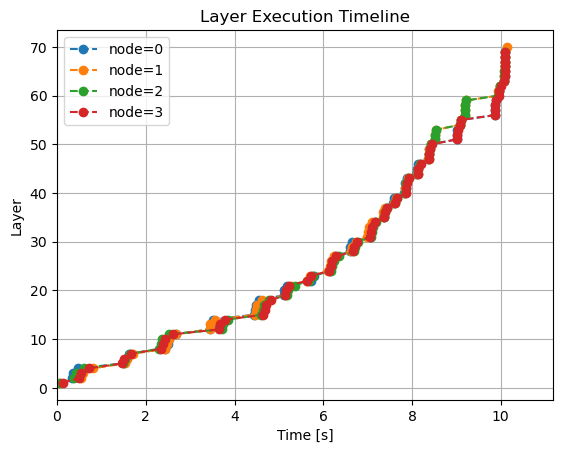

In [10]:
'''
    Look at layer execution times
'''

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):
    plt.plot(execute_layer_ts_df[execute_layer_ts_df['node'] == i]['timestamp'] ,execute_layer_ts_df[execute_layer_ts_df['node'] == i]['layer'], '--o')
    legend_strs += [f'node={i}']
plt.title('Layer Execution Timeline')
plt.xlabel('Time [s]')
plt.ylabel('Layer')
plt.legend(legend_strs)
#_ = plt.xticks(np.arange(0, 10, step=1))
plt.xlim(0,max(total_runtime)*1.1)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'layer_execution_time.jpg'))



In [11]:
total_exec_time

2875.77879964374

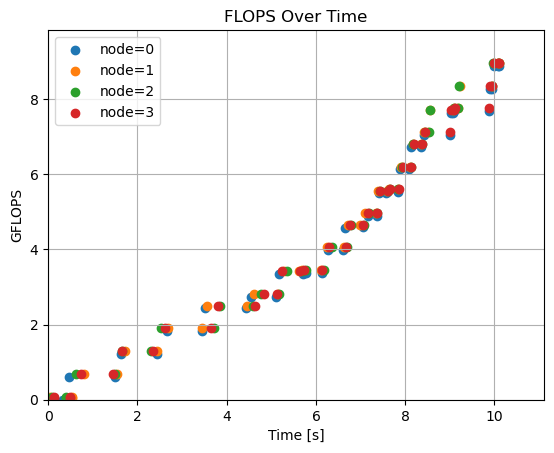

In [12]:
merged_layer_df = pd.merge(execute_layer_ts_df, flops_df, on=['layer_name', 'node', 'layer'], how='right')
merged_layer_df.sort_values(by=['timestamp_x'])
max
plt.figure()
plt.grid()
legend_strs = []
for i in range(4):

    tmp_merged_layer_df = merged_layer_df[merged_layer_df['node'] == i]
    cum_bytes = np.cumsum(tmp_merged_layer_df['FLOPS'].to_numpy())
    plt.scatter(tmp_merged_layer_df['timestamp_x'] ,cum_bytes/1e9)
    legend_strs += [f'node={i}']
plt.title('FLOPS Over Time')
plt.xlabel('Time [s]')
plt.ylabel('GFLOPS')
_ = plt.legend(legend_strs)
plt.xlim(0, max(merged_layer_df['timestamp_x'])*1.1)
plt.ylim(0,sum(merged_layer_df['FLOPS'])*1.1/1e9/num_nodes)
#_ = plt.xticks(np.arange(0, 250, step=20))

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'FLOPS.jpg'))


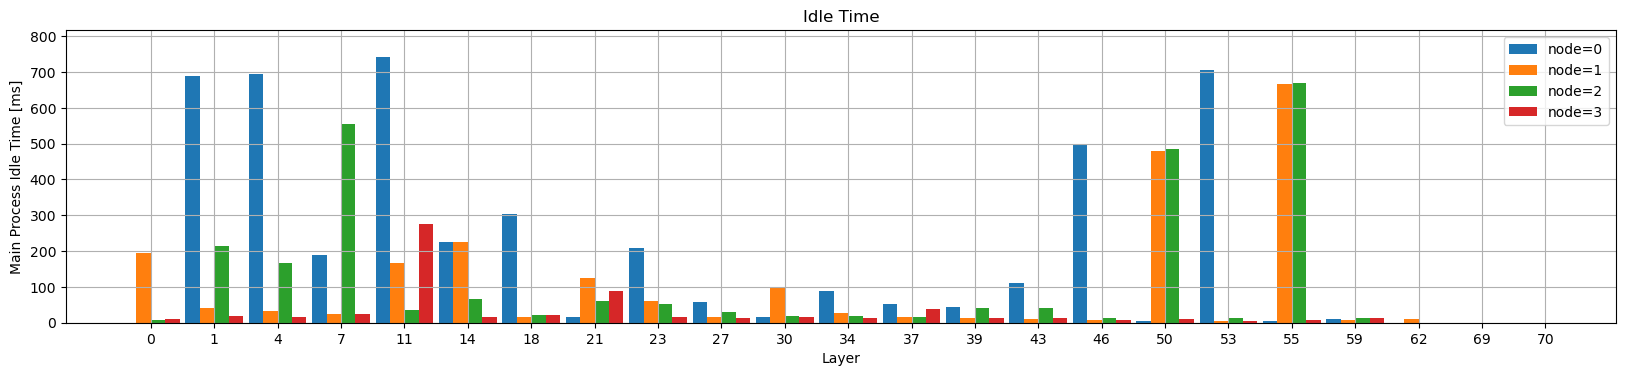

In [13]:
'''
    Look at idling durations
    - idle time includes time spent receiving
    - idle time does not include time spent sending 
    - idle time does not include time spent doing split layer computation 

    # TODO: put bars next to one another 
'''

width = 4
uniq_layers = np.unique(master_df['layer'])  # map layer number to bar index
num_layers= len(uniq_layers)
layer_array = np.arange(num_layers)

plt.figure(figsize=(20,3.8))
plt.grid()
legend_strs = []
for i in range(4):
    # map arrays to indexes on plot
    index_map = np.isin(uniq_layers, master_df[master_df['node'] == i]['layer']).nonzero()[0]
    plt.bar(  index_map*17.6+width*(i-1.5) ,master_df[master_df['node'] == i]['idle_time'], width)
    legend_strs += [f'node={i}']
plt.title('Idle Time')
plt.xlabel('Layer')
plt.ylabel('Main Process Idle Time [ms]')
plt.legend(legend_strs)


_ = plt.xticks(layer_array*17.6, uniq_layers)
plt.ylim(0, max(master_df['idle_time'])*1.1)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'idle_time.jpg'))


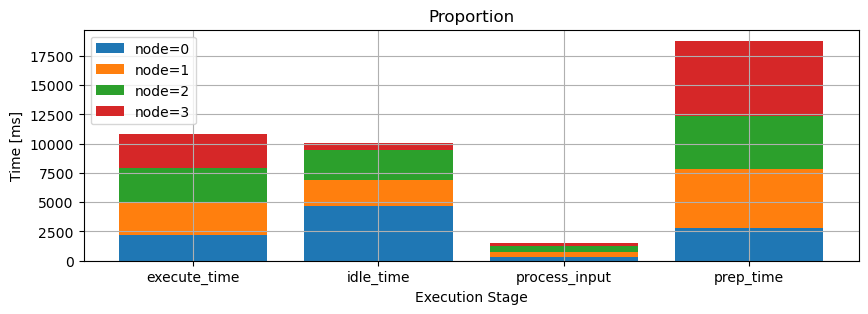

In [14]:
'''
    WIP Compare durations from different states 

'''

stages = ["execute_time", "idle_time", "process_input", "prep_time"]
num_stages = len(stages)
legend_strs = []

plt.figure(figsize=(10,3))
plt.grid()
bot = np.zeros(num_stages)
for inode in range(4):

    stages_array = master_df[stages][master_df['node'] == inode].sum(axis=0).to_numpy()
    plt.bar(stages, stages_array, bottom=bot)
    bot += stages_array

    legend_strs += [f'node={inode}']

plt.title('Proportion')
plt.xlabel('Execution Stage')
plt.ylabel('Time [ms]')
plt.legend(legend_strs)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'proportion.jpg'))

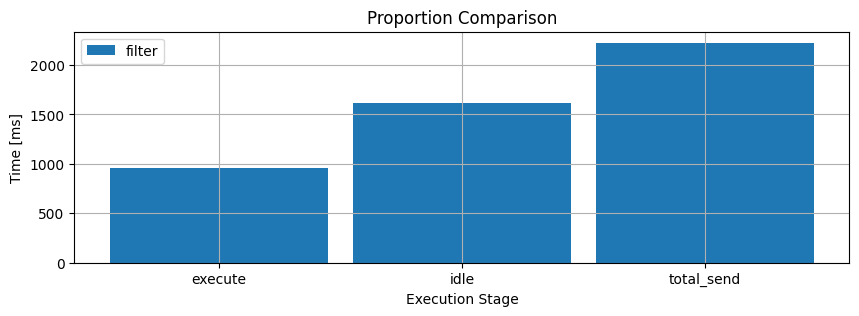

In [197]:
'''
    WIP Compare durations from different states 

    # TODO: put bars next to one another 

'''

stages = ["execute", "idle", "total_send"]
num_stages = len(stages)
stage_values = np.arange(num_stages)*num_runs
legend_strs = []

width = 0.9

plt.figure(figsize=(10,3))
plt.grid()

irun = 0
for run_name in run_names:
    master_df = combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] 

    stages_array = np.array([])
    for a_stage in stages:
        stages_array = np.append(stages_array, master_df[master_df['type'] == a_stage]['dur'].sum(axis=0))

    plt.bar(stage_values + irun*width - num_runs*width/2, stages_array, width=width, align='edge')

    legend_strs += [run_name]
    irun += 1

plt.xticks(stage_values, stages)
#plt.xscale('log')

plt.title('Proportion Comparison')
plt.xlabel('Execution Stage')
plt.ylabel('Time [ms]')
plt.legend(legend_strs)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_compare_adjacent.jpg'))

In [ ]:
'''
    WIP Compare runtimes from different runs 

    # TODO: put bars next to one another 

'''

stages = ["execute", "idle", "total_send"]
stage_values = np.arange(num_stages)*num_runs
legend_strs = []

width = 0.9

plt.figure(figsize=(10,3))
plt.grid()

irun = 0
data_frames = []
for run_name in run_names:
    data_frames[run_name] = combine_log_files(os.path.join('logs', run_name), log_name, num_nodes)[0] 

    stages_array = np.array([])
    for a_stage in stages:
        stages_array = np.append(stages_array, master_df[master_df['type'] == a_stage]['dur'].sum(axis=0))

    plt.bar(stage_values + irun*width - num_runs*width/2, stages_array, width=width, align='edge')

    legend_strs += [run_name]
    irun += 1

plt.xticks(stage_values, run_names)
#plt.xscale('log')

plt.title('Proportion Comparison')
plt.xlabel('Execution Stage')
plt.ylabel('Time [ms]')
plt.legend(legend_strs)

#_ = plt.xticks(layer_array*17.6, uniq_layers)
#plt.ylim(0, 50)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'state_compare_stacked.jpg'))

In [124]:
''' 
    prep time taking a long time?
    or is it the cleaning of the queue?
'''

import torch 
import time 

for flag in [0,1]:
    queue_data = []
    for i in range(5):
        adict = {
            'layer': 1,
            'tensor':torch.rand((64, 128, 128))
            }
        queue_data.append(adict)

    queue_data[0]['layer'] = -1

    start = time.perf_counter() 
    if not flag:
        queue_data = [el for el in queue_data if el['layer'] != -1]
        method_str = 'list comp'
    else:
        method_str = 'filter'
        queue_data = list(filter(lambda el: el['layer'] != -1, queue_data))
    dur = time.perf_counter() -start

    print(f'method {method_str} : {dur}')


method list comp : 0.00023519998649135232
method filter : 0.00031880001188255847


In [120]:
a = (filter(lambda el: el['layer'] != -1, queue_data))
type(a)


filter